CNN for Fake News classification

In [0]:
from keras.models import Sequential
from keras import layers
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np




In [0]:
# parameter adjustments for fake news
maxlen = 100
max_features = 50000
train_glove = True   # Turn on/off for trainnable glove

In [0]:
# Reading files
train = pd.read_csv("/content/drive/My Drive/cmpt400/dataset/train.csv")
valid = pd.read_csv("/content/drive/My Drive/cmpt400/dataset/valid.csv")
test = pd.read_csv("/content/drive/My Drive/cmpt400/dataset/test.csv")
train_va = pd.concat([train,valid])

In [48]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_va['news'])

# tokenize text 
X_train = tokenizer.texts_to_sequences(train_va['news'])
X_test = tokenizer.texts_to_sequences(test['news'])

# turn categories into integer representation
y_train = pd.factorize(train_va['label'])[0]+1
y_test = pd.factorize(test['label'])[0]+1

#calculate the total vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# pad each news to maxlen
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

n_timesteps, n_features = X_train.shape[0], X_train.shape[1]
print(n_timesteps)
print(n_features)

# print(X_train)

# print(X_test)
# print(y_train)



11524
100


In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Read in glove file


In [0]:
def txt_create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [0]:
import numpy as np
from gensim.models import KeyedVectors
def bin_create_embedding_matrix(filepath,word_index,embedding_dim):
  vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
  # embedding_matrix = np.zeros((vocab_size, embedding_dim))
  # calculate how many word will be used
  num_words = min(max_features,vocab_size)
  # get a random matrix
  embedding_matrix = (np.random.rand(num_words, embedding_dim) - 0.5) / 5.0
  embeddings_index = KeyedVectors.load_word2vec_format(filepath, binary=True)

  for word, i in word_index.items():
    if i >= max_features: continue
    if word in embeddings_index:
      embeddings_vector = embeddings_index.get_vector(word)
      embedding_matrix[i] = embeddings_vector
  return embedding_matrix

In [52]:
#created the glove matrix
embedding_dim = 300
filepath_news = '/content/drive/My Drive/cmpt400/dataset/GoogleNews-vectors-negative300.bin'
filepath_6b = '/content/drive/My Drive/cmpt400/dataset/glove.6B.50d.txt'
embedding_matrix = bin_create_embedding_matrix(filepath_news,tokenizer.word_index, embedding_dim)
print(len(embedding_matrix))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


13110


In [53]:
# 93% coverage for the glove matrix, not bad
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)

1.0


In [116]:
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.losses import categorical_crossentropy
from keras.losses import sparse_categorical_crossentropy
train_glove = False
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim,weights=[embedding_matrix], input_length=maxlen,trainable=train_glove))
model.add(layers.Conv1D(filters=128,kernel_size= 2, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(layers.Conv1D(filters=128,kernel_size= 3, activation='relu'))
model.add(layers.Conv1D(filters=128,kernel_size= 4, activation='relu'))
model.add(layers.GlobalMaxPool1D())             # Maybe try concatenate layers by using max and avg
# model.add(layers.GlobalAveragePooling1D())        # Averagepooling is easy to get stuck, find local min right away
model.add(layers.Dropout(0.8))
model.add(layers.Dense(7, activation='softmax'))
model.compile(optimizer=SGD(lr=0.001),loss=sparse_categorical_crossentropy,metrics=['accuracy'],)     # 0.001 seems to give the best output
model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_47 (Embedding)     (None, 100, 300)          3933000   
_________________________________________________________________
conv1d_139 (Conv1D)          (None, 99, 128)           76928     
_________________________________________________________________
conv1d_140 (Conv1D)          (None, 97, 128)           49280     
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 94, 128)           65664     
_________________________________________________________________
global_max_pooling1d_35 (Glo (None, 128)               0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 7)               

Train on 10238 samples, validate on 1286 samples
Epoch 1/20
 - 4s - loss: 1.8312 - acc: 0.1900 - val_loss: 1.7806 - val_acc: 0.1952
Epoch 2/20
 - 1s - loss: 1.7805 - acc: 0.2080 - val_loss: 1.7418 - val_acc: 0.2465
Epoch 3/20
 - 1s - loss: 1.7548 - acc: 0.2176 - val_loss: 1.7334 - val_acc: 0.2449
Epoch 4/20
 - 1s - loss: 1.7394 - acc: 0.2340 - val_loss: 1.7221 - val_acc: 0.2551
Epoch 5/20
 - 1s - loss: 1.7220 - acc: 0.2384 - val_loss: 1.7085 - val_acc: 0.2597
Epoch 6/20
 - 1s - loss: 1.7039 - acc: 0.2482 - val_loss: 1.7251 - val_acc: 0.2512
Epoch 7/20
 - 1s - loss: 1.6732 - acc: 0.2656 - val_loss: 1.7000 - val_acc: 0.2551
Epoch 8/20
 - 1s - loss: 1.6445 - acc: 0.2859 - val_loss: 1.7047 - val_acc: 0.2566
Epoch 9/20
 - 1s - loss: 1.6005 - acc: 0.3013 - val_loss: 1.7257 - val_acc: 0.2535
Epoch 10/20
 - 1s - loss: 1.5546 - acc: 0.3197 - val_loss: 1.7296 - val_acc: 0.2582
Epoch 11/20
 - 1s - loss: 1.4967 - acc: 0.3449 - val_loss: 1.7655 - val_acc: 0.2457
Epoch 12/20
 - 1s - loss: 1.4322 - a

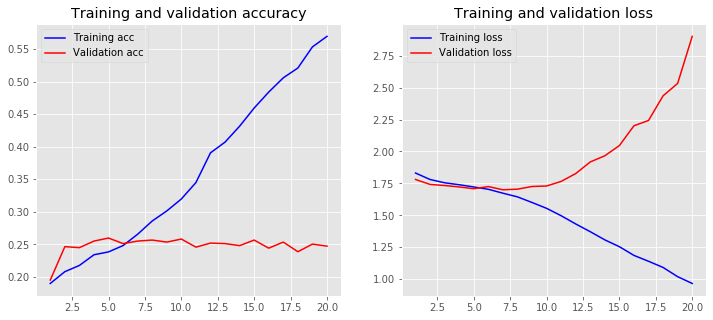

In [117]:

history = model.fit(X_train[:-1286], y_train[:-1286], epochs=20, verbose=2, validation_data=(X_train[-1286:], y_train[-1286:]),batch_size=64)
# history = model.fit(X_train[:-1286], y_train[:-1286], epochs=20, verbose=2, validation_data=(X_test, y_test),batch_size=64)
loss, accuracy = model.evaluate(X_train, y_train, verbose=2)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [0]:
# import tensorflow as tf
# import random as rn
# import os


# from tensorflow import set_random_seed
# set_random_seed(2)

# os.environ['PYTHONHASHSEED'] = '0'

# # Setting the seed for numpy-generated random numbers
# np.random.seed(37)

# # Setting the seed for python random numbers
# rn.seed(1254)

# # Setting the graph-level random seed.
# tf.set_random_seed(89)

# from keras import backend as K

# session_conf = tf.ConfigProto(
#       intra_op_parallelism_threads=1,
#       inter_op_parallelism_threads=1)

# #Force Tensorflow to use a single thread
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# K.set_session(sess)

# # Rest of the code follows from here on ...